Целью данного проекта является проведение разведывательного анализа для выявления влияния условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

Для достижения этой цели нужно:
1. очистить собранные данные от некорректных значений,
2. отсеить выбросы для числовых данных, оставить только те, числовые переменные, которые не зависят друг от друга (низкая корреляция),
3. для номинативных переменных оценить ститистическую значимость разницы оценок в зависимости от значений переменной


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np

In [2]:
# загрузка данных
studmath = pd.read_csv('/users/antonzubov/Documents/Projects/dscource/module_2/stud_math.xls')

In [3]:
# переименовываем колонки
studmath.columns = [x.replace(', ', '_').lower() for x in studmath.columns]

In [4]:
# смотрим сводную информацию по данным
studmath.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   pstatus             350 non-null    object 
 6   medu                392 non-null    float64
 7   fedu                371 non-null    float64
 8   mjob                376 non-null    object 
 9   fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

Введем вспомогательные функции и переменные

In [5]:
# функция выводит уникальные данные в колонке column для датафрейма df
def showUniqueValues(df, column):
    print(column)
    display(df[column].unique())

# функция заменяет пропущенные значения на None
def replaceInvalidValuesWithNone(df, column):
    df[column] = df[column].apply(lambda x: None if pd.isnull(x) else x)

# функция заменяет недопустимые числовые значения в колонке column для датафрейма df
# allowedValues содержит список допустимых значений.
def replaceValuesOutOfRangeWithNone(df, column, allowedValues):
    df[column] = df[column].apply(lambda x: x if x in allowedValues else None)

# функция заменяет недопустимые строковые значения в колонке column для датафрейма df
# allowedValues содержит список допустимых значений
# все значения приводятся к нижнему регистру, тк регистр не несет смыслового значения
# и можно скорректировать заполеннные данные если они не в том регистре, что заявлено в описании задания
def replaceStrValuesOutOfRangeWithNone(df, column, allowedValues):
    df[column] = df[column].apply(lambda x: None if pd.isnull(x) else x.lower() if x.lower() in allowedValues else None)

# функция удаляет выбросы в числовой колонке column датафрейма df
def removeOutliers(df, column):
    df[column].plot(kind='box')
    plt.title(column)
    q25 = df[column].quantile(0.25)
    q75 = df[column].quantile(0.75)
    iqr = q75 - q25
    lowmargin = q25 - 1.5*iqr
    uppermargin = q75 + 1.5*iqr
    df[column] = df[column].apply(lambda x: x if ((x >lowmargin) and (x<uppermargin)) else None)
    
# функция показывает частоту уникальных значений в колонке column датафрейма df
def showDistribution(df, column):
    print("Колонка ", column)
    display(df[column].value_counts(dropna=True, normalize=True))
    print("Количество уникальных значений", len(df[column].unique()))
    print("Количество пустых значений", len(df[column])-df[column].count())
    
# функция для отображения распределения значений score для уникальных значений колонки column датафрейма df
def get_boxplot(df, column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index)],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

# функция проверки гипотезы, что значения score отличаются для уникальных значений колонки column датафрейма df
# возвращает True если есть статистически значимое различие
def get_stat_dif(df, column):
    result = False
    cols = df.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            result = True
            break
    return result

# вспомогательные списки числовых и номинативных колонок
numColumns = ['age','medu','fedu','traveltime','studytime','failures','studytime_granular','famrel','freetime','goout','health']
catColumns = ['school','sex','address','famsize','pstatus','mjob','fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']

# инициализируем итоговый список колонок, которые будут использоваться в дальнейшем
columnsToPreserve =['score']


In [6]:
# предварительная зачистка данных
for colName in studmath.columns:
    replaceInvalidValuesWithNone(studmath, colName)

# для всех номинативных колонок и колонок, содержащих номера категорий, выбрасываем значения,
# которые не соответсвуют ожидаемым
replaceStrValuesOutOfRangeWithNone(studmath, 'sex', ['m', 'f'])
replaceValuesOutOfRangeWithNone(studmath, 'age', range(15,23))
replaceStrValuesOutOfRangeWithNone(studmath, 'address', ['u','r'])
replaceStrValuesOutOfRangeWithNone(studmath, 'famsize', ['le3', 'gt3'])
replaceStrValuesOutOfRangeWithNone(studmath, 'pstatus', ['t','a'])
replaceValuesOutOfRangeWithNone(studmath, 'medu', [0,1,2,3,4])
replaceValuesOutOfRangeWithNone(studmath, 'fedu', [0,1,2,3,4])
replaceStrValuesOutOfRangeWithNone(studmath, 'mjob', ['teacher', 'health', 'services', 'at_home', 'other'])
replaceStrValuesOutOfRangeWithNone(studmath, 'fjob', ['teacher', 'health', 'services', 'at_home', 'other'])
replaceStrValuesOutOfRangeWithNone(studmath, 'reason', ['home', 'reputation', 'cource', 'other'])
replaceStrValuesOutOfRangeWithNone(studmath, 'guardian', ['mother', 'father', 'other'])
replaceValuesOutOfRangeWithNone(studmath, 'traveltime', [1,2,3,4])
replaceValuesOutOfRangeWithNone(studmath, 'studytime', [1,2,3,4])
replaceValuesOutOfRangeWithNone(studmath, 'failures', [0,1,2,3])
replaceStrValuesOutOfRangeWithNone(studmath, 'schoolsup', ['yes', 'no'])
replaceStrValuesOutOfRangeWithNone(studmath, 'famsup', ['yes', 'no'])
replaceStrValuesOutOfRangeWithNone(studmath, 'paid', ['yes', 'no'])
replaceStrValuesOutOfRangeWithNone(studmath, 'activities', ['yes', 'no'])
replaceStrValuesOutOfRangeWithNone(studmath, 'nursery', ['yes', 'no'])
replaceStrValuesOutOfRangeWithNone(studmath, 'higher', ['yes', 'no'])
replaceStrValuesOutOfRangeWithNone(studmath, 'internet', ['yes', 'no'])
replaceStrValuesOutOfRangeWithNone(studmath, 'romantic', ['yes', 'no'])
replaceValuesOutOfRangeWithNone(studmath, 'famrel', [1,2,3,4,5])
replaceValuesOutOfRangeWithNone(studmath, 'freetime', [1,2,3,4,5])
replaceValuesOutOfRangeWithNone(studmath, 'goout', [1,2,3,4,5])
replaceValuesOutOfRangeWithNone(studmath, 'health', [1,2,3,4,5])


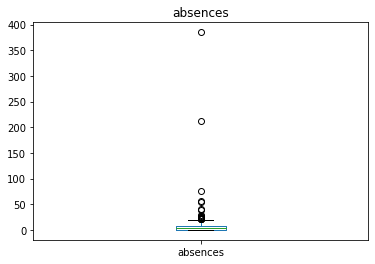

In [7]:
# удалять выбросы нужно только для чисто числовых колонок (не кодирующих ни какие категории)
# удаляем выбросы для прогулов
removeOutliers(studmath, 'absences')


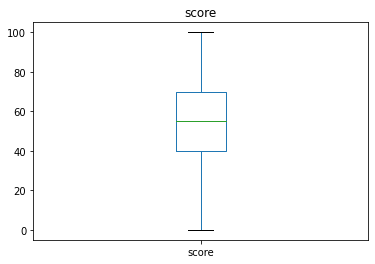

In [8]:
# удаляем выбросы для оценки
removeOutliers(studmath, 'score')
# оставляем в датафрейме только записи с заполненным полем score
studmath = studmath.loc[~pd.isnull(studmath.score)]

In [9]:
#  смотрим на распределение значений по колонкам
for colName in studmath.columns:
    showDistribution(studmath, colName)

Колонка  school


GP    0.884319
MS    0.115681
Name: school, dtype: float64

Количество уникальных значений 2
Количество пустых значений 0
Колонка  sex


f    0.524422
m    0.475578
Name: sex, dtype: float64

Количество уникальных значений 2
Количество пустых значений 0
Колонка  age


16    0.264781
17    0.251928
15    0.210797
18    0.205656
19    0.053985
20    0.007712
22    0.002571
21    0.002571
Name: age, dtype: float64

Количество уникальных значений 8
Количество пустых значений 0
Колонка  address


u    0.778075
r    0.221925
Name: address, dtype: float64

Количество уникальных значений 3
Количество пустых значений 15
Колонка  famsize


gt3    0.70442
le3    0.29558
Name: famsize, dtype: float64

Количество уникальных значений 3
Количество пустых значений 27
Колонка  pstatus


t    0.895349
a    0.104651
Name: pstatus, dtype: float64

Количество уникальных значений 3
Количество пустых значений 45
Колонка  medu


4.0    0.339378
2.0    0.259067
3.0    0.248705
1.0    0.145078
0.0    0.007772
Name: medu, dtype: float64

Количество уникальных значений 6
Количество пустых значений 3
Колонка  fedu


2.0    0.288462
3.0    0.258242
4.0    0.241758
1.0    0.206044
0.0    0.005495
Name: fedu, dtype: float64

Количество уникальных значений 6
Количество пустых значений 25
Колонка  mjob


other       0.343243
services    0.264865
at_home     0.156757
teacher     0.148649
health      0.086486
Name: mjob, dtype: float64

Количество уникальных значений 6
Количество пустых значений 19
Колонка  fjob


other       0.549575
services    0.280453
teacher     0.082153
at_home     0.045326
health      0.042493
Name: fjob, dtype: float64

Количество уникальных значений 6
Количество пустых значений 36
Колонка  reason


reputation    0.43038
home          0.42616
other         0.14346
Name: reason, dtype: float64

Количество уникальных значений 4
Количество пустых значений 152
Колонка  guardian


mother    0.692737
father    0.240223
other     0.067039
Name: guardian, dtype: float64

Количество уникальных значений 4
Количество пустых значений 31
Колонка  traveltime


1.0    0.662050
2.0    0.260388
3.0    0.058172
4.0    0.019391
Name: traveltime, dtype: float64

Количество уникальных значений 5
Количество пустых значений 28
Колонка  studytime


2.0    0.494764
1.0    0.269634
3.0    0.164921
4.0    0.070681
Name: studytime, dtype: float64

Количество уникальных значений 5
Количество пустых значений 7
Колонка  failures


0.0    0.790191
1.0    0.130790
2.0    0.040872
3.0    0.038147
Name: failures, dtype: float64

Количество уникальных значений 5
Количество пустых значений 22
Колонка  schoolsup


no     0.871053
yes    0.128947
Name: schoolsup, dtype: float64

Количество уникальных значений 3
Количество пустых значений 9
Колонка  famsup


yes    0.615385
no     0.384615
Name: famsup, dtype: float64

Количество уникальных значений 3
Количество пустых значений 38
Колонка  paid


no     0.562857
yes    0.437143
Name: paid, dtype: float64

Количество уникальных значений 3
Количество пустых значений 39
Колонка  activities


yes    0.512
no     0.488
Name: activities, dtype: float64

Количество уникальных значений 3
Количество пустых значений 14
Колонка  nursery


yes    0.794118
no     0.205882
Name: nursery, dtype: float64

Количество уникальных значений 3
Количество пустых значений 15
Колонка  studytime_granular


-6.0     0.494764
-3.0     0.269634
-9.0     0.164921
-12.0    0.070681
Name: studytime_granular, dtype: float64

Количество уникальных значений 5
Количество пустых значений 7
Колонка  higher


yes    0.948509
no     0.051491
Name: higher, dtype: float64

Количество уникальных значений 3
Количество пустых значений 20
Колонка  internet


yes    0.84507
no     0.15493
Name: internet, dtype: float64

Количество уникальных значений 3
Количество пустых значений 34
Колонка  romantic


no     0.656425
yes    0.343575
Name: romantic, dtype: float64

Количество уникальных значений 3
Количество пустых значений 31
Колонка  famrel


4.0    0.493075
5.0    0.268698
3.0    0.171745
2.0    0.047091
1.0    0.019391
Name: famrel, dtype: float64

Количество уникальных значений 6
Количество пустых значений 28
Колонка  freetime


3.0    0.400000
4.0    0.289474
2.0    0.165789
5.0    0.097368
1.0    0.047368
Name: freetime, dtype: float64

Количество уникальных значений 6
Количество пустых значений 9
Колонка  goout


3.0    0.329843
2.0    0.264398
4.0    0.212042
5.0    0.133508
1.0    0.060209
Name: goout, dtype: float64

Количество уникальных значений 6
Количество пустых значений 7
Колонка  health


5.0    0.366310
3.0    0.235294
4.0    0.160428
1.0    0.125668
2.0    0.112299
Name: health, dtype: float64

Количество уникальных значений 6
Количество пустых значений 15
Колонка  absences


0.0     0.308123
2.0     0.168067
4.0     0.145658
6.0     0.084034
8.0     0.056022
10.0    0.047619
14.0    0.033613
12.0    0.033613
16.0    0.019608
3.0     0.019608
7.0     0.016807
5.0     0.014006
18.0    0.014006
1.0     0.008403
9.0     0.008403
11.0    0.005602
13.0    0.005602
15.0    0.005602
19.0    0.002801
17.0    0.002801
Name: absences, dtype: float64

Количество уникальных значений 21
Количество пустых значений 32
Колонка  score


50.0     0.138817
55.0     0.118252
0.0      0.095116
75.0     0.084833
65.0     0.079692
40.0     0.079692
60.0     0.079692
70.0     0.069409
45.0     0.069409
80.0     0.041131
30.0     0.038560
90.0     0.030848
35.0     0.023136
25.0     0.017995
85.0     0.015424
95.0     0.012853
100.0    0.002571
20.0     0.002571
Name: score, dtype: float64

Количество уникальных значений 18
Количество пустых значений 0


Для колонок остались только ожидаемые значения.
Для колонки reason много пустых значений (почти половина) - видимо, не все смогли или захотели ответить на вопрос о причине выбора школы.
По остальным колонкам не так много пропусков.

In [10]:
# для числовых колонок считаем корреляцию
studmath.corr()

,age,medu,fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.146736,-0.147952,0.073146,-0.018227,0.205919,0.018227,0.054846,0.016099,0.121115,-0.068103,0.133498,-0.155726
medu,-0.146736,1.000000,0.626536,-0.165838,0.081032,-0.240319,-0.081032,-0.010205,0.038265,0.072320,-0.048331,0.096191,0.213349
fedu,-0.147952,0.626536,1.000000,-0.142170,0.013009,-0.272352,-0.013009,-0.026481,-0.012749,0.054938,0.017321,-0.007497,0.130002
traveltime,0.073146,-0.165838,-0.142170,1.000000,-0.105910,0.049738,0.105910,-0.039304,-0.026299,0.032629,-0.011724,-0.086609,-0.070559
studytime,-0.018227,0.081032,0.013009,-0.105910,1.000000,-0.181947,-1.000000,0.029253,-0.125066,-0.053831,-0.079180,-0.067155,0.115741
failures,0.205919,-0.240319,-0.272352,0.049738,-0.181947,1.000000,0.181947,0.000506,0.091608,0.107747,0.088013,0.071433,-0.344338
studytime_granular,0.018227,-0.081032,-0.013009,0.105910,-1.000000,0.181947,1.000000,-0.029253,0.125066,0.053831,0.079180,0.067155,-0.115741
famrel,0.054846,-0.010205,-0.026481,-0.039304,0.029253,0.000506,-0.029253,1.000000,0.162715,0.064314,0.100807,-0.069989,0.051219
freetime,0.016099,0.038265,-0.012749,-0.026299,-0.125066,0.091608,0.125066,0.162715,1.000000,0.296338,0.064315,0.089239,0.019026
goout,0.121115,0.072320,0.054938,0.032629,-0.053831,0.107747,0.053831,0.064314,0.296338,1.000000,-0.018026,0.132140,-0.129685


Корреляция показала обратную зависимость studytime и studytime granular. Последнюю можно исключить из анализа.
Колонки age и absences остаются для дальнейшего анализа.

Т.к. большенство числовых колонок являются номерами неких категорий, то построим по этим категориям распределение score:

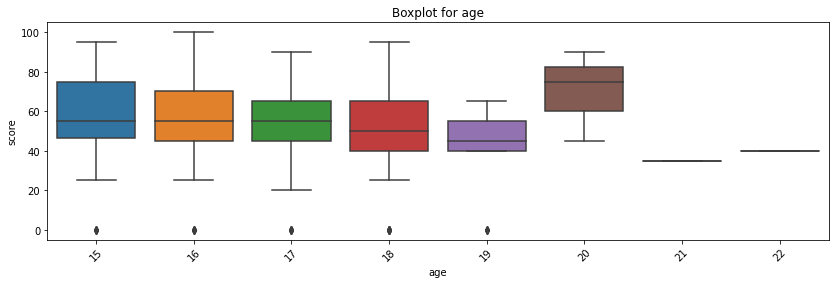

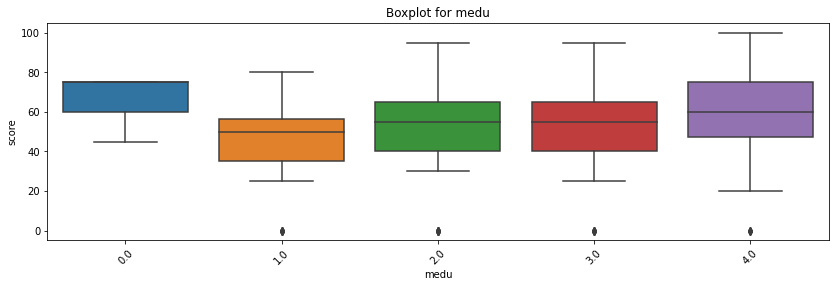

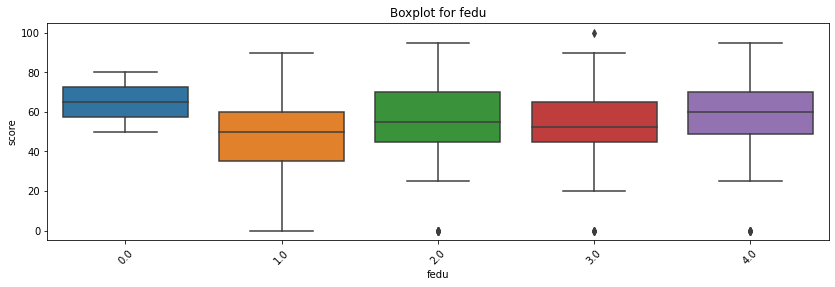

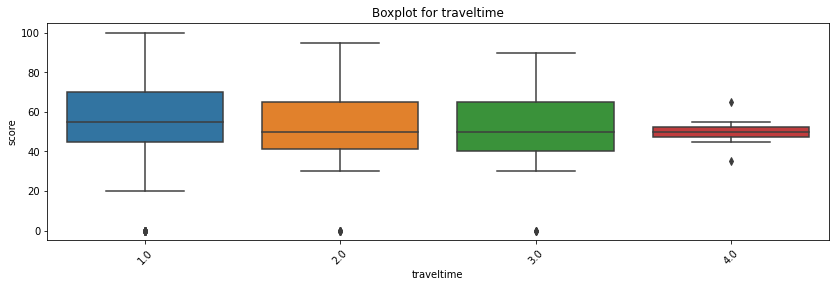

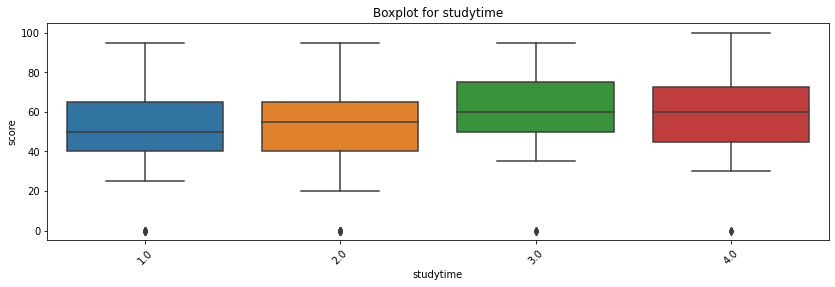

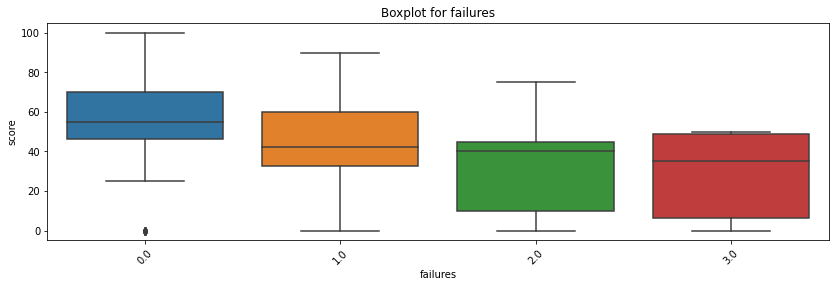

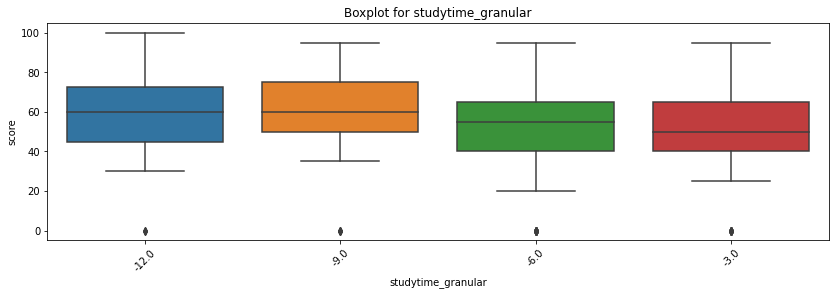

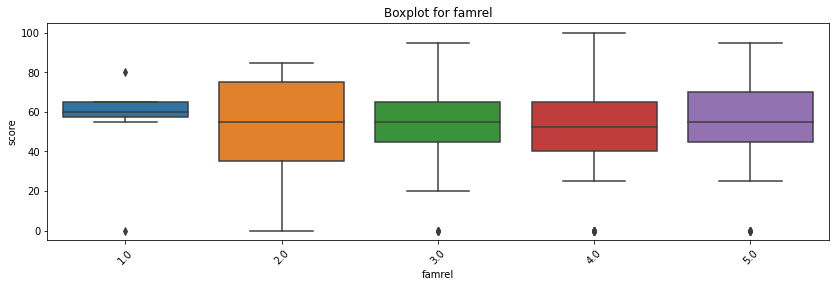

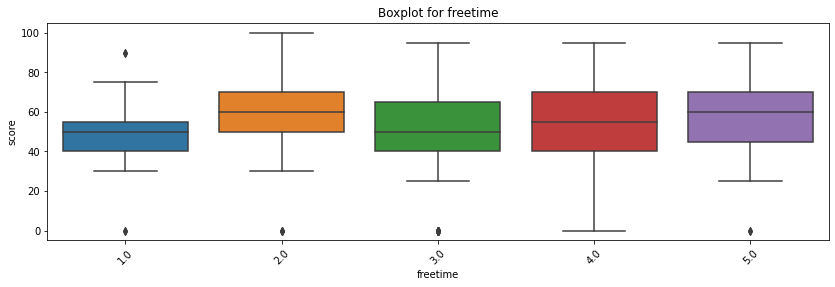

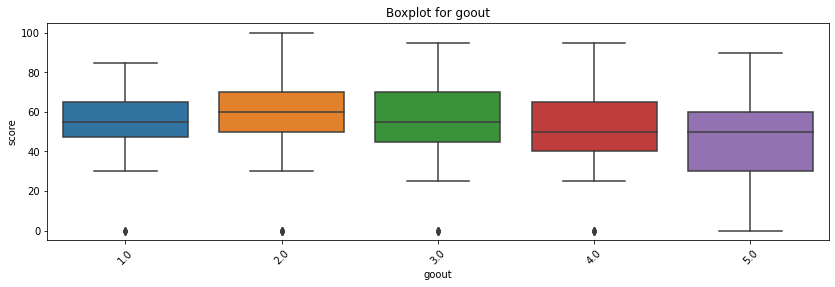

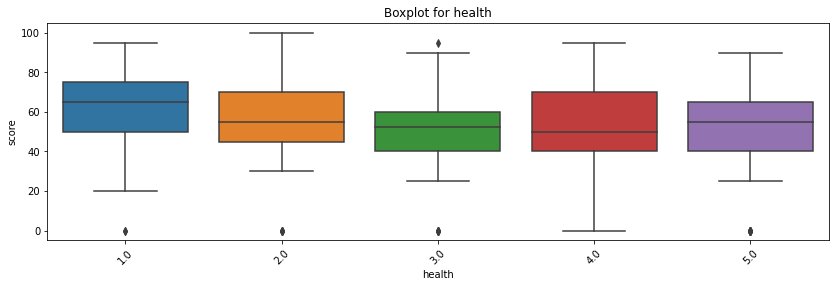

In [11]:
for col in numColumns:
    get_boxplot(studmath, col)

In [12]:
# средние значения и размахи по категориям в каждой колонке различаются
# посчитаем, для каких колонок различие в score по категориям является статистически значимым
for col in numColumns:
    if get_stat_dif(studmath, col):
        columnsToPreserve.append(col)
# get_stat_dif(studmath, 'health')

Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки goout


/Users/antonzubov/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/antonzubov/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Теперь проведем аналогичный анализ по номинативным колонкам.

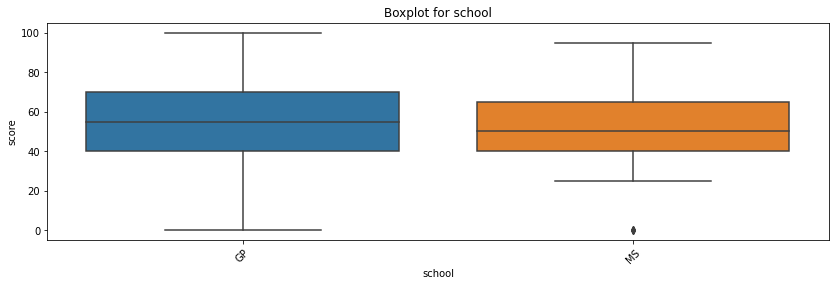

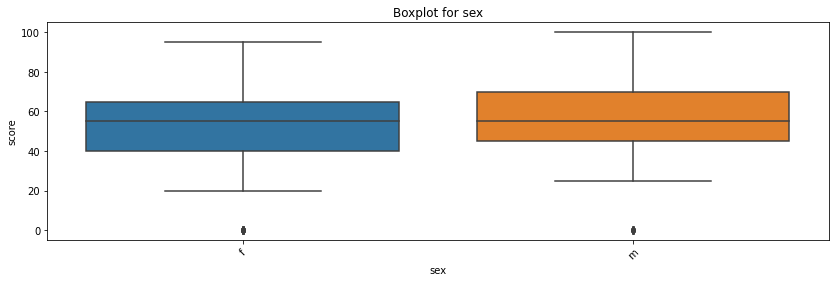

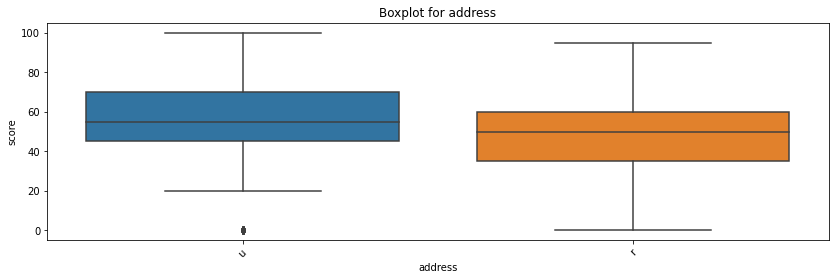

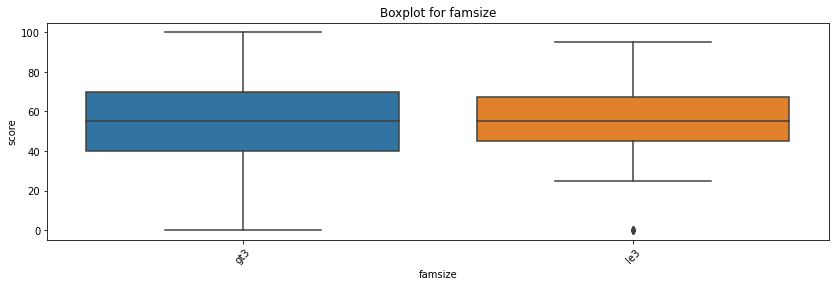

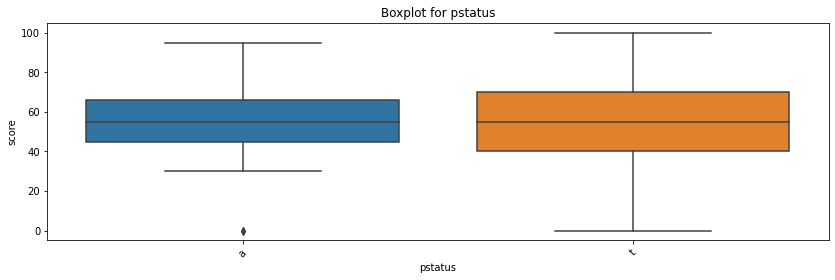

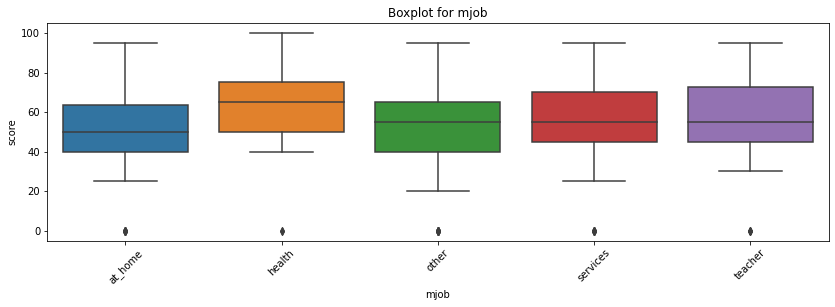

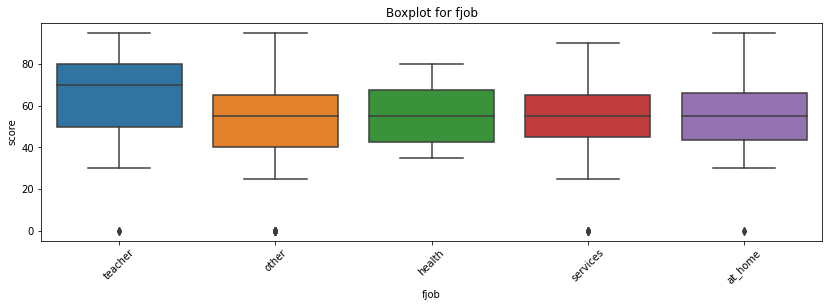

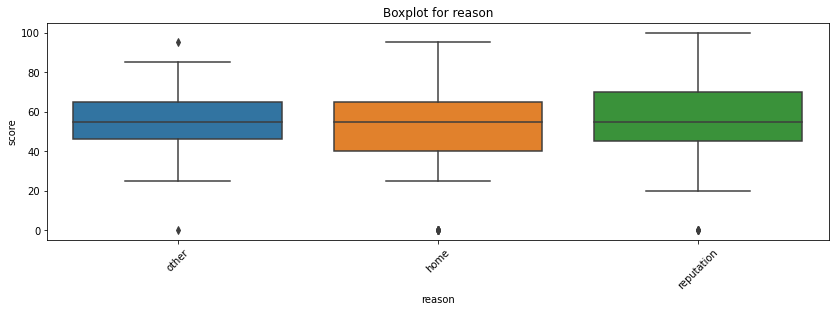

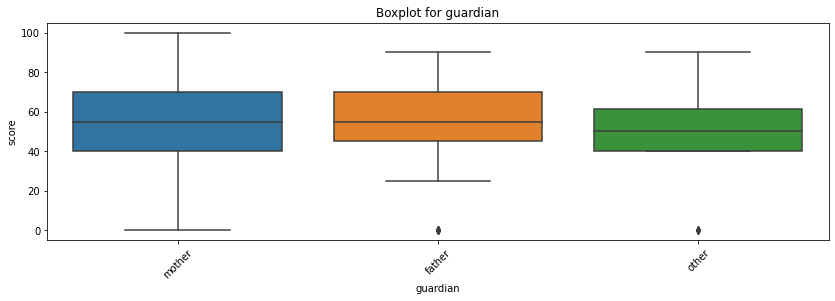

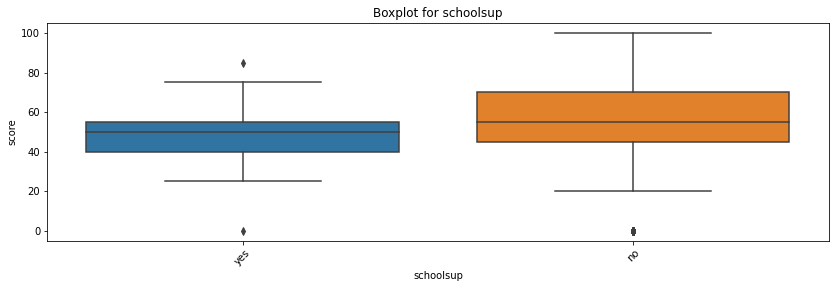

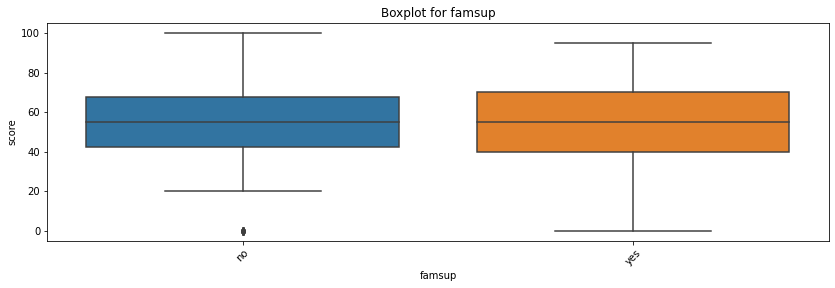

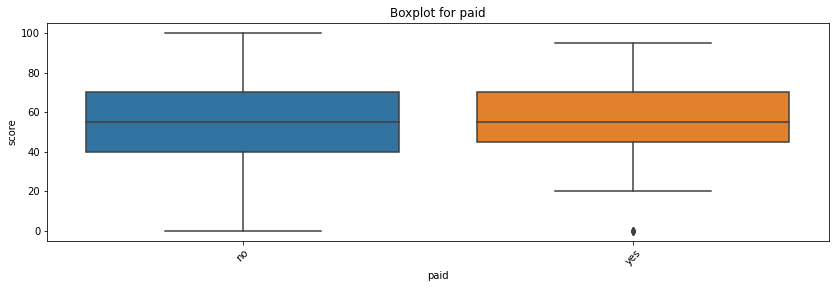

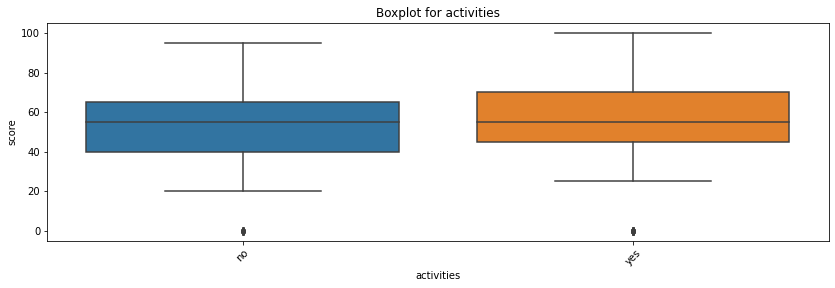

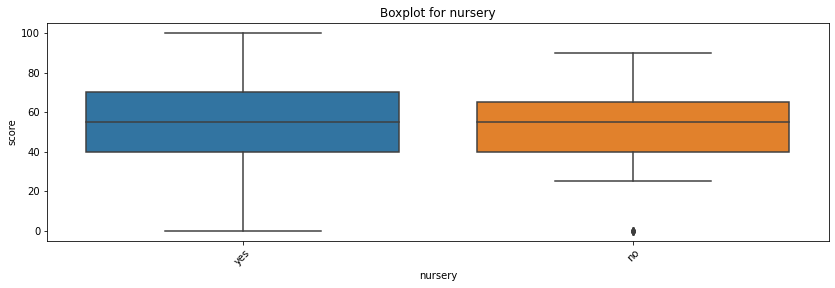

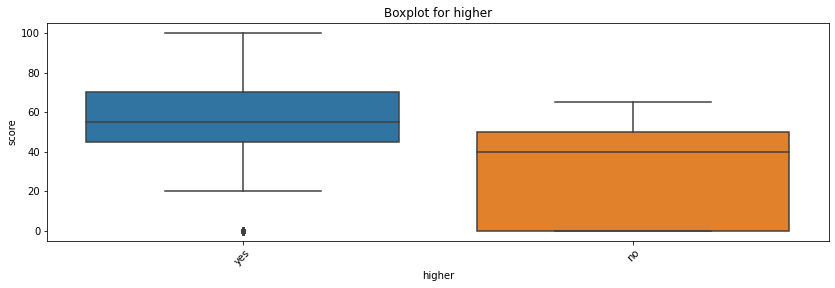

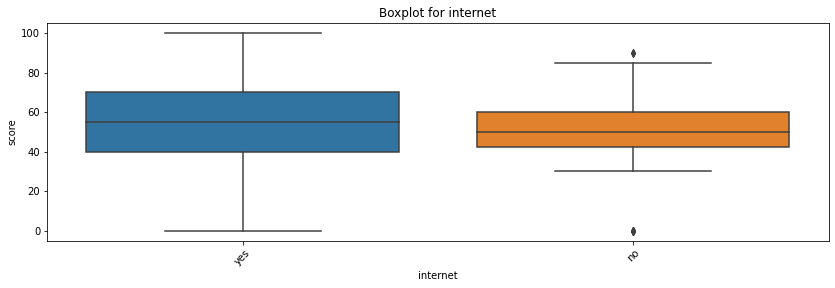

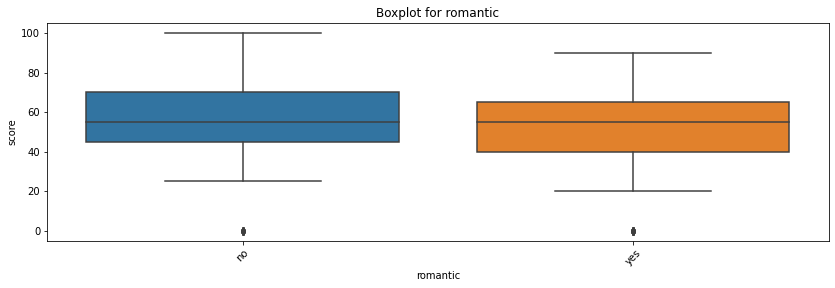

In [13]:
# строим распределение score по признакам из номинативных колонок
for col in catColumns:
    get_boxplot(studmath, col)


Колонки school, address, mjob, fjob, guardian, schoolsup, higher, internet кандидаты на значимость.
Тем не менее посчитаем, для каких колонок распределение score по категориям является статистически значимым.

In [14]:
for col in catColumns:
    if get_stat_dif(studmath, col):
        columnsToPreserve.append(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


In [15]:
# колонки, которые будут участвовать в дальнейшем построении модели
print(columnsToPreserve)
# оставляем в датафрейме только выбранные колонки
studmath = studmath.loc[:, columnsToPreserve]
display(studmath)

['score', 'medu', 'failures', 'goout', 'address', 'mjob', 'higher', 'romantic']


,score,medu,failures,goout,address,mjob,higher,romantic
0,30.0,4.0,0.0,4.0,u,at_home,yes,no
1,30.0,1.0,0.0,3.0,u,at_home,yes,no
2,50.0,1.0,3.0,2.0,u,at_home,yes,None
3,75.0,4.0,0.0,2.0,u,health,yes,yes
4,50.0,3.0,0.0,2.0,u,other,yes,no
...,...,...,...,...,...,...,...,...
390,45.0,2.0,2.0,4.0,u,services,yes,no
391,80.0,3.0,0.0,5.0,u,services,yes,no
392,35.0,1.0,3.0,3.0,r,other,None,no
393,50.0,3.0,0.0,1.0,r,services,yes,no
